# Calculate the vertical action dispersion as a function of gyrochronology age. Now with RVs

These results look great. Things to do next include:
1. Use distance posteriors provided in the literature.
2. Calculate vertical actions with uncertainties, including correlations between parameters.
3. Use van Saders models too (bring Jen on board).
4. Compare with Jason Sanders' theoretical models.
5. Write the paper.

First of all, load Megan Bedell's Kepler-DR2 crossmatched table, crossmatch with the McQuillan catalogue and see how many of these stars have RVs and rotation periods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from actions import action

Load Megan's table and add parallax uncertainty column. 

In [2]:
dat = Table.read('data/kepler_dr2_4arcsec.fits', format='fits')
d = dat.to_pandas()
d["relative_parallax_err"] = d.parallax_error.values / d.parallax.values

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()



Load the McQuillan catalogues.

In [3]:
M1 = pd.read_csv("data/Table_1_Periodic.txt")
M2 = pd.read_csv("data/Table_2_Non_Periodic.txt")

Crossmatch the two catalogues.

In [4]:
df0 = pd.merge(d, M1, on="kepid", how="inner", suffixes=["_gk", "_mc"])
df0.keys()

Index(['angDist', 'kepid', 'source_id', 'ra_gaia', 'ra_error', 'dec_gaia',
       'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
       'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       'tm_designation', 'ra_kic', 'dec_kic', 'kepmag', 'teff', 'teff_err1',
       'teff_err2', 'teff_prov', 'logg_gk', 'logg_err1', 'logg_err2',
       'logg_prov', 'feh', 'feh_err1', 'feh_err2', 'feh_prov', 'radius',
       'radius_err1', 'radius_err2', 'mass', 'mass_err1', 'mass_err2',
       'prov_sec', 'nconfp', 'nkoi', 'ntce', 'jmag', 'hmag', 'kmag',
       'kepoi_name', 'planet?', 'relative_parallax_err', 'Teff', 'logg_mc',
       'Mass', 'Prot', 'Prot_err', 'R

In [5]:
print(np.shape(df0)[0] - np.shape(M1)[0])  # I think this increases because some stars appear twice in d. Need to remove dups.

8271


Remove stars with bad parallaxes, stars without RVs, hot stars and evolved stars.

In [6]:
m = df0.relative_parallax_err.values < .1
m = np.isfinite(df0.radial_velocity.values)
m &= df0.teff.values < 6250
m &= 4.1 < df0.logg_gk.values

df = df0.iloc[m]
print(np.shape(df0), np.shape(df))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':

(42301, 72) (1612, 72)


Plot Teff vs log g.

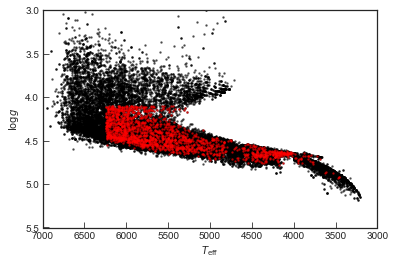

In [7]:
plt.plot(df0.teff, df0.logg_gk, ".k", ms=3, alpha=0.5)
plt.plot(df.teff, df.logg_gk, ".r", ms=3, alpha=0.5)
plt.xlim(7000, 3000)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");

Calculate vertical actions for these stars.

In [8]:
jrs, lzs, jzs, z, vts = [np.zeros(len(df.kepid.values)) for i in range(5)]
for i, star in enumerate(df.kepid.values):
    # Calculate actions
    R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, lz, Jz = \
        action(df.ra_gaia.values[i], df.dec_gaia.values[i], 1./df.parallax.values[i], 
        df.pmra.values[i], df.pmdec.values[i], df.radial_velocity.values[i])
           
    jrs[i], lzs[i], jzs[i], z[i], vts[i] = jR, lz, Jz, z_kpc, vT_kms
    if i % 100 == 0:
        print(i, "of", len(df.kepid.values))
        print("Vertical action = ", z[i])

0 of 1612
Vertical action =  0.04415876859897604
/Users/ruthangus/anaconda/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):

/Users/ruthangus/anaconda/lib/python3.5/site-packages/numpy/lib/scimath.py:172: RuntimeWarning: invalid value encountered in greater
  if any(isreal(x) & (abs(x) > 1)):

100 of 1612
Vertical action =  0.09129340562511187
200 of 1612
Vertical action =  0.1465862320825221
300 of 1612
Vertical action =  0.09558494428441254
400 of 1612
Vertical action =  0.13310692877858685
500 of 1612
Vertical action =  0.146616513360163
600 of 1612
Vertical action =  0.13653894881711537
700 of 1612
Vertical action =  0.09893560779476923
800 of 1612
Vertical action =  0.14954955600792857
900 of 1612
Vertical action =  0.0537207513025509
1000 of 1612
Vertical action =  0.04272729605253115
1100 of 1612
Vertical action =  0.06122634766273053
1200 of 1612
Vertical action =  0.07614867999824639
1300 of 

In [9]:
df["jz"] = jzs
df.to_csv("data/mcquillan_stars_with_vertical_action.csv")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':



In [10]:
df = pd.read_csv("data/mcquillan_stars_with_vertical_action.csv")

Now plot rotation period against vertical action.

Text(0,0.5,'Vertical action')

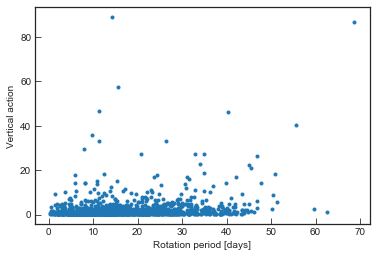

In [11]:
plt.plot(df.Prot.values, df.jz.values, ".")
plt.xlabel("Rotation period [days]")
plt.ylabel("Vertical action")

And rotation period against vertical action dispersion.

In [12]:
# remove nans and sort stars by increasing period.
m = np.isfinite(df.jz.values)
df2 = df.iloc[m]

inds = np.argsort(df2.Prot.values)
sorted_periods = df2.Prot.values[inds]
sorted_jz = df2.jz.values[inds]

Calculate running dispersion.

In [13]:
# Calculate dispersion in each bin.
from astropy.stats import median_absolute_deviation as MAD

nstars_in_bin = 100  # number of stars in each bin.
nbins = len(sorted_jz) - nstars_in_bin
dispersions, xs, errs = [np.zeros(nbins) for i in range(3)]
for i in range(nbins):
    dispersions[i] = MAD(sorted_jz[i:i+nstars_in_bin])
    xs[i] = sorted_periods[i]

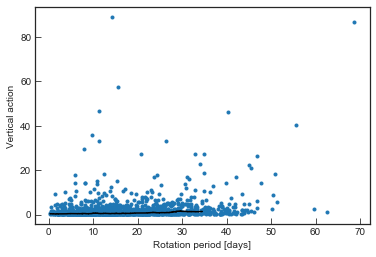

In [14]:
plt.plot(df.Prot.values, df.jz.values, ".")
plt.xlabel("Rotation period [days]")
plt.ylabel("Vertical action")
plt.step(xs, dispersions, "k")

And whatever the opposite of running dispersion is.

In [15]:
# Calculate dispersion in each bin.
nstars_in_bin = 100  # number of stars in each bin.
nbins = int(len(sorted_jz) / nstars_in_bin) + 1
dispersions, xs, errs = [np.zeros(nbins) for i in range(3)]
for i in range(nbins-1):
    dispersions[i] = MAD(sorted_jz[i*nstars_in_bin:(i+1)*nstars_in_bin])
    xs[i] = np.mean(sorted_periods[i*nstars_in_bin:(i+1)*nstars_in_bin])
dispersions[-1] = MAD(sorted_jz[(i+1)*nstars_in_bin:])
xs[-1] = np.mean(sorted_periods[(i+1)*nstars_in_bin:])

Text(0,0.5,'MAD(Vertical action)')

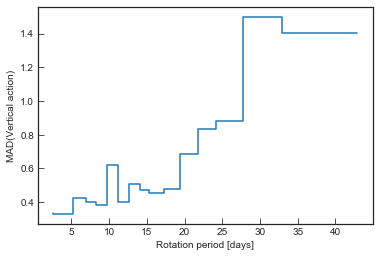

In [16]:
plt.step(xs, dispersions)
plt.xlabel("Rotation period [days]")
plt.ylabel("MAD(Vertical action)")

Now take a look at age as a function of vertical action dispersion.

Calculate ages.

In [46]:
import scipy.spatial as sps

# Jen's gyro model
def vansaders_age(t, p):
    """ Calculate an age from a luminosity, temperature and rotation period.
    Uses a KDtree to find the nearest point in Jen van Saders'
    evolutionary tracks.
    Currently has only solar metallicity.
    To do:
    Use interpolation instead of nearest.
    Include other metallicities.
    params:
    ------
    t: (float)
        Teff in K
    p: (float)
        rotation Period in days

    returns:
    -------
    age: (float)
        Age in Gyr
    """
    vs = pd.read_csv("data/skeleton3_run_000.out", skiprows=172)
    m = (3000 < 10**vs.log_Teff_K.values) & (10**vs.log_Teff_K.values < 8000) & (vs.Age_Gyr > .1)
    teff = 10**vs.log_Teff_K.values[m]
    P = vs.Prot_days.values[m]
    age = vs.Age_Gyr.values[m]
    data = np.vstack((teff, P)).T
    tree = sps.cKDTree(data)
    dist, index = tree.query([t, p], 1)
    return age[index]

In [47]:
# Simple power-law gyro model
import teff_bv as tbv

bvs = tbv.teff2bv(df2.teff.values, df2.logg_gk.values, df2.feh.values)
a, b, c, n = .4, .31, .45, .55  # Angus values
ages = (df2.Prot.values/(a*(bvs - c)**b))**(1./n)*1e-3

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power



In [49]:
# Actually use Jen's ages.
ages = np.zeros(len(df2.Prot.values))
for i in range(len(ages)):
    print(i, "of", len(ages))
    ages[i] = vansaders_age(df2.teff.values[i], df2.Prot.values[i])

0 of 1574
1 of 1574
2 of 1574
3 of 1574
4 of 1574
5 of 1574
6 of 1574
7 of 1574
8 of 1574
9 of 1574
10 of 1574
11 of 1574
12 of 1574
13 of 1574
14 of 1574
15 of 1574
16 of 1574
17 of 1574
18 of 1574
19 of 1574
20 of 1574
21 of 1574
22 of 1574
23 of 1574
24 of 1574
25 of 1574
26 of 1574
27 of 1574
28 of 1574
29 of 1574
30 of 1574
31 of 1574
32 of 1574
33 of 1574
34 of 1574
35 of 1574
36 of 1574
37 of 1574
38 of 1574
39 of 1574
40 of 1574
41 of 1574
42 of 1574
43 of 1574
44 of 1574
45 of 1574
46 of 1574
47 of 1574
48 of 1574
49 of 1574
50 of 1574
51 of 1574
52 of 1574
53 of 1574
54 of 1574
55 of 1574
56 of 1574
57 of 1574
58 of 1574
59 of 1574
60 of 1574
61 of 1574
62 of 1574
63 of 1574
64 of 1574
65 of 1574
66 of 1574
67 of 1574
68 of 1574
69 of 1574
70 of 1574
71 of 1574
72 of 1574
73 of 1574
74 of 1574
75 of 1574
76 of 1574
77 of 1574
78 of 1574
79 of 1574
80 of 1574
81 of 1574
82 of 1574
83 of 1574
84 of 1574
85 of 1574
86 of 1574
87 of 1574
88 of 1574
89 of 1574
90 of 1574
91 of 157

In [50]:
# Sort the ages
inds = np.argsort(ages)
sorted_ages = ages[inds]
sorted_jz = df2.jz.values[inds]

In [51]:
# Calculate dispersion in each bin.
nstars_in_bin = 100  # number of stars in each bin.
nbins = int(len(sorted_jz) / nstars_in_bin) + 1
dispersions, xs, errs = [np.zeros(nbins) for i in range(3)]
for i in range(nbins-1):
    dispersions[i] = MAD(sorted_jz[i*nstars_in_bin:(i+1)*nstars_in_bin])
    xs[i] = np.mean(sorted_ages[i*nstars_in_bin:(i+1)*nstars_in_bin])
dispersions[-1] = MAD(sorted_jz[(i+1)*nstars_in_bin:])
xs[-1] = np.mean(sorted_ages[(i+1)*nstars_in_bin:])

Text(0,0.5,'MAD(Vertical action)')

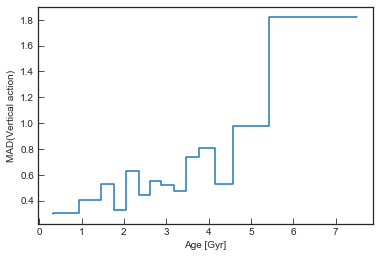

In [52]:
plt.step(xs, dispersions)
plt.xlabel("Age [Gyr]")
plt.ylabel("MAD(Vertical action)")

Load and plot Jason Sanders' theoretical models to compare to this.

In [53]:
sanders = pd.read_csv("data/dwarf.txt")

(0, 5)

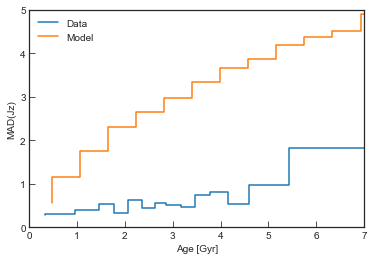

In [55]:
plt.step(xs, dispersions, label="Data")
plt.step(sanders.age.values, sanders.jz.values, label="Model")
plt.legend(loc="upper left")
plt.xlabel("Age [Gyr]")
plt.ylabel("MAD(Jz)")
plt.xlim(0, 7)
plt.ylim(0, 5)

Not sure I'm comparing apples to apples here -- need to ask Jason exactly what goes into these numbers.

Now calculate ages using the van Saders model.

In [56]:
# Simple power-law gyro model
import teff_bv as tbv

bvs = tbv.teff2bv(df2.teff.values, df2.logg_gk.values, df2.feh.values)
a, b, c, n = .4, .31, .45, .55  # Angus values
ages2 = (df2.Prot.values/(a*(bvs - c)**b))**(1./n)*1e-3

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power



In [57]:
# Sort the ages
inds = np.argsort(ages2)
sorted_ages2 = ages2[inds]
sorted_jz = df2.jz.values[inds]

In [58]:
# Calculate dispersion in each bin.
nstars_in_bin = 100  # number of stars in each bin.
nbins = int(len(sorted_jz) / nstars_in_bin) + 1
dispersions2, xs2, errs2 = [np.zeros(nbins) for i in range(3)]
for i in range(nbins-1):
    dispersions2[i] = MAD(sorted_jz[i*nstars_in_bin:(i+1)*nstars_in_bin])
    xs2[i] = np.mean(sorted_ages2[i*nstars_in_bin:(i+1)*nstars_in_bin])
dispersions2[-1] = MAD(sorted_jz[(i+1)*nstars_in_bin:])
xs2[-1] = np.mean(sorted_ages2[(i+1)*nstars_in_bin:])

(0, 5)

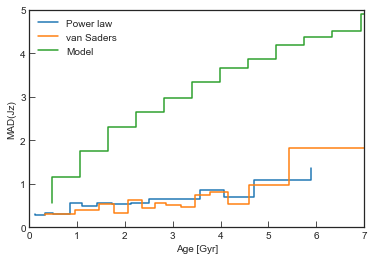

In [61]:
plt.step(xs2, dispersions2, label="Power law")
plt.step(xs, dispersions, label="van Saders")
plt.step(sanders.age.values, sanders.jz.values, label="Model")
plt.legend(loc="upper left")
plt.xlabel("Age [Gyr]")
plt.ylabel("MAD(Jz)")
plt.xlim(0, 7)
plt.ylim(0, 5)

(0, 2)

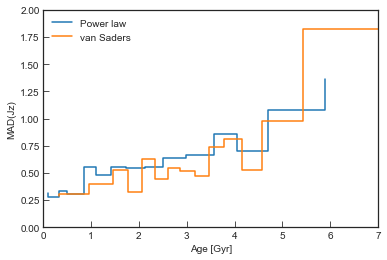

In [63]:
plt.step(xs2, dispersions2, label="Power law")
plt.step(xs, dispersions, label="van Saders")
#plt.step(sanders.age.values, sanders.jz.values, label="Model")
plt.legend(loc="upper left")
plt.xlabel("Age [Gyr]")
plt.ylabel("MAD(Jz)")
plt.xlim(0, 7)
plt.ylim(0, 2)